
# ①データ、ライブラリ読み込み
---



In [ ]:
# Gドライブをマウント
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#データの読み込み
import pandas as pd

train_features_original = pd.read_csv('gdrive/My Drive/train_features.csv')
train_drug_original = pd.read_csv('gdrive/My Drive/train_drug.csv')
train_targets_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
train_targets_nonscored_original = pd.read_csv('gdrive/My Drive/train_targets_nonscored.csv')
test_features_original = pd.read_csv('gdrive/My Drive/test_features.csv')
columns_original = pd.read_csv('gdrive/My Drive/train_targets_scored.csv')
sample_original = pd.read_csv('gdrive/My Drive/sample_submission.csv')

In [ ]:
#データコピー
train_features = train_features_original.copy()
train_targets_scored = train_targets_original.copy()
train_targets_nonscored = train_targets_nonscored_original.copy()
test_features = test_features_original.copy()
sample_submission = sample_original.copy()

#ライブラリインポート
!pip install iterative-stratification
!pip install japanize_matplotlib
import japanize_matplotlib
import sys

import numpy as np
import random
import pandas as pd
import os
import copy
import gc

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import scipy.stats as stats
from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#パラメータの指定
#ここはいろんなノートブックの知見から最適条件を探したと思われる
n_comp_GENES = 463 #PCAで何個の変数に減らすか
n_comp_CELLS = 60
VarianceThreshold_for_FS = 0.9 #変数選択の際の分散の閾値
Dropout_Model = 0.25 #Dropoutの値を指定
NUM_EPOCHS = 35   #エポック数を指定

# ②RankGauss処理を実施

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

In [ ]:
# RankGauss - transform to Gauss
for col in (GENES + CELLS):
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")   # from optimal commit 9
    vec_len = len(train_features[col].values)
    vec_len_test = len(test_features[col].values)
    raw_vec = train_features[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_features[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_features[col] = transformer.transform(test_features[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

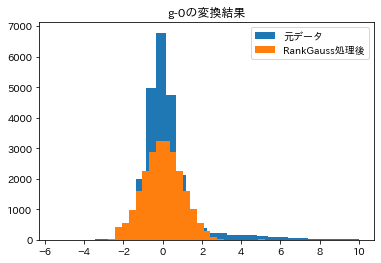

In [ ]:
#結果の確認
plt.hist(train_features_original['g-0'],bins=30,label='元データ')
plt.hist(train_features['g-0'],bins=30,label='RankGauss処理後')
plt.title('g-0の変換結果')
plt.legend()
plt.show()

In [ ]:
#Seedの設定
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# ③PCAの実施

In [ ]:
len(GENES)

772

In [ ]:
#g-の説明変数を772⇒463に次元削減
#一度traintとtestを縦に結合
data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])

#PCAにより次元削減
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))

#trainとtestに分割
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

#PCA結果をデータフレーム化
train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

#元データに結合
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,pca_G-423,pca_G-424,pca_G-425,pca_G-426,pca_G-427,pca_G-428,pca_G-429,pca_G-430,pca_G-431,pca_G-432,pca_G-433,pca_G-434,pca_G-435,pca_G-436,pca_G-437,pca_G-438,pca_G-439,pca_G-440,pca_G-441,pca_G-442,pca_G-443,pca_G-444,pca_G-445,pca_G-446,pca_G-447,pca_G-448,pca_G-449,pca_G-450,pca_G-451,pca_G-452,pca_G-453,pca_G-454,pca_G-455,pca_G-456,pca_G-457,pca_G-458,pca_G-459,pca_G-460,pca_G-461,pca_G-462
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,...,0.379174,-0.127598,-1.186298,0.181231,-0.187305,-0.148041,0.353513,-0.038499,-0.885999,-0.447300,0.098243,-0.466394,-0.043670,-0.252983,-0.331903,-1.326270,-0.168816,0.642467,-0.159091,-0.201643,0.224383,0.560282,0.142594,0.144186,-0.104307,-0.392602,0.849481,-0.020403,0.116056,-0.346398,0.230565,0.496674,0.063970,0.499296,-0.749474,-0.038545,0.203088,1.153143,-0.977564,0.367489
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,...,0.126527,0.446497,-0.642708,0.091668,-0.467905,-0.092406,0.080794,-0.402897,-0.049122,0.056618,-0.260721,-0.407052,-0.590813,-0.409394,-0.402181,-0.490310,0.665796,1.078072,0.900804,-0.433809,1.168776,-0.586100,0.543351,-0.064541,0.246071,-0.745788,-0.232640,0.910069,0.367672,-0.588841,-0.514369,0.102665,-0.957519,-0.252207,1.142073,-0.595059,-0.616196,0.505521,-0.564365,0.103394
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,...,0.539881,0.301282,0.521107,1.187741,0.341701,-0.486634,0.194121,-0.803929,0.407193,-1.227354,-0.241351,-0.295929,-0.747047,-0.623250,0.292790,0.324589,0.001361,0.313807,0.542658,0.179159,-0.094206,0.481831,-0.365578,0.372919,0.193667,0.610057,-0.040028,0.938505,0.142499,-0.309115,0.391376,-0.769848,-0.834966,0.596595,0.323498,0.907264,-0.222588,0.339208,-0.817093,-0.272242
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,...,0.444299,-1.057570,0.232632,-0.768453,-0.560757,0.794964,0.292362,0.785640,0.381922,0.511551,-0.313008,-0.059083,0.187171,-0.344709,0.368814,0.942896,0.966252,0.299831,1.539251,-0.208392,0.267419,-0.139801,0.010809,0.170843,-0.878709,-0.467401,-0.614185,-0.487830,-0.618232,-0.613549,0.014381,0.049012,0.195408,0.241371,0.322106,0.020644,-0.349103,0.470498,0.261949,-0.187674
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,...

In [ ]:
len(CELLS)

100

In [ ]:
#c-の説明変数を100⇒60に次元削減
data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [ ]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,pca_C-20,pca_C-21,pca_C-22,pca_C-23,pca_C-24,pca_C-25,pca_C-26,pca_C-27,pca_C-28,pca_C-29,pca_C-30,pca_C-31,pca_C-32,pca_C-33,pca_C-34,pca_C-35,pca_C-36,pca_C-37,pca_C-38,pca_C-39,pca_C-40,pca_C-41,pca_C-42,pca_C-43,pca_C-44,pca_C-45,pca_C-46,pca_C-47,pca_C-48,pca_C-49,pca_C-50,pca_C-51,pca_C-52,pca_C-53,pca_C-54,pca_C-55,pca_C-56,pca_C-57,pca_C-58,pca_C-59
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,...,-0.371116,0.066643,-0.528892,0.265141,-1.362092,0.295361,-0.715955,-0.257248,-0.808422,0.097765,-0.581690,0.065010,-0.360714,-1.146817,-0.857211,0.963224,-0.984587,0.747240,-1.623858,0.859884,0.263211,0.655209,0.233247,1.438599,-0.589675,0.881429,-0.674612,0.890363,-0.184627,-0.038839,-0.514146,0.727106,0.631370,0.588790,-0.623881,-0.584221,0.139658,-0.748875,-0.090711,0.508949
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,...,-0.544004,-0.415498,-0.330223,0.474379,-1.077613,0.899279,-0.075400,0.139926,0.596299,0.457722,-0.312746,-0.156435,-0.899764,-0.291183,0.085381,-0.385726,-0.454929,0.488570,-1.014052,-0.431739,0.242256,-0.184513,0.869380,0.698796,0.334966,-1.095600,0.437594,0.277690,-0.620344,-0.002239,-1.439262,0.508808,1.712656,-0.095448,-0.052959,-0.427382,-0.789533,-0.677906,-0.006642,0.581791
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,...,-0.534507,1.396301,0.437780,-0.231204,1.057334,0.201807,-1.013902,-1.030785,-0.292956,-0.974122,0.875335,0.027566,-1.008860,0.913110,-0.339925,-0.324881,-0.293107,0.105349,1.133511,0.915979,0.086268,0.308164,0.983641,1.121542,-0.723254,-0.478249,0.259912,0.006745,0.648037,-0.169007,-0.491030,0.259354,-0.724947,0.138275,-0.128793,-1.059011,-1.629201,0.177806,-0.776725,-0.204851
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,...,-0.150355,0.121987,0.090553,0.491135,0.107982,0.153183,-0.295710,0.130761,0.600676,-0.120013,0.269239,-0.390087,-0.016607,0.043999,0.610698,-1.100798,0.914388,0.973542,-0.051966,-0.585115,-0.276984,-0.510565,0.430786,0.126073,0.197427,0.129967,0.298150,-0.482725,-0.138976,-0.309638,0.545759,0.197091,-0.058694,0.616253,-0.000931,0.135783,-0.326965,0.131044,0.061892,-0.054619
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,...,0.858798,0.764955,0.409902,0.99132

# ④変数選択

In [ ]:
data = train_features.append(test_features)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,pca_C-20,pca_C-21,pca_C-22,pca_C-23,pca_C-24,pca_C-25,pca_C-26,pca_C-27,pca_C-28,pca_C-29,pca_C-30,pca_C-31,pca_C-32,pca_C-33,pca_C-34,pca_C-35,pca_C-36,pca_C-37,pca_C-38,pca_C-39,pca_C-40,pca_C-41,pca_C-42,pca_C-43,pca_C-44,pca_C-45,pca_C-46,pca_C-47,pca_C-48,pca_C-49,pca_C-50,pca_C-51,pca_C-52,pca_C-53,pca_C-54,pca_C-55,pca_C-56,pca_C-57,pca_C-58,pca_C-59
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,...,-0.371116,0.066643,-0.528892,0.265141,-1.362092,0.295361,-0.715955,-0.257248,-0.808422,0.097765,-0.581690,0.065010,-0.360714,-1.146817,-0.857211,0.963224,-0.984587,0.747240,-1.623858,0.859884,0.263211,0.655209,0.233247,1.438599,-0.589675,0.881429,-0.674612,0.890363,-0.184627,-0.038839,-0.514146,0.727106,0.631370,0.588790,-0.623881,-0.584221,0.139658,-0.748875,-0.090711,0.508949
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,...,-0.544004,-0.415498,-0.330223,0.474379,-1.077613,0.899279,-0.075400,0.139926,0.596299,0.457722,-0.312746,-0.156435,-0.899764,-0.291183,0.085381,-0.385726,-0.454929,0.488570,-1.014052,-0.431739,0.242256,-0.184513,0.869380,0.698796,0.334966,-1.095600,0.437594,0.277690,-0.620344,-0.002239,-1.439262,0.508808,1.712656,-0.095448,-0.052959,-0.427382,-0.789533,-0.677906,-0.006642,0.581791
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,...,-0.534507,1.396301,0.437780,-0.231204,1.057334,0.201807,-1.013902,-1.030785,-0.292956,-0.974122,0.875335,0.027566,-1.008860,0.913110,-0.339925,-0.324881,-0.293107,0.105349,1.133511,0.915979,0.086268,0.308164,0.983641,1.121542,-0.723254,-0.478249,0.259912,0.006745,0.648037,-0.169007,-0.491030,0.259354,-0.724947,0.138275,-0.128793,-1.059011,-1.629201,0.177806,-0.776725,-0.204851
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,...,-0.150355,0.121987,0.090553,0.491135,0.107982,0.153183,-0.295710,0.130761,0.600676,-0.120013,0.269239,-0.390087,-0.016607,0.043999,0.610698,-1.100798,0.914388,0.973542,-0.051966,-0.585115,-0.276984,-0.510565,0.430786,0.126073,0.197427,0.129967,0.298150,-0.482725,-0.138976,-0.309638,0.545759,0.197091,-0.058694,0.616253,-0.000931,0.135783,-0.326965,0.131044,0.061892,-0.054619
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,...,0.858798,0.764955,0.409902,0.99132

In [ ]:
#分散が0.9以下の変数を削除する
var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

In [ ]:
#削除された変数を確認
remove_column_list=data.columns[4:][np.logical_not(var_thresh.get_support())]
remove_column_list

Index(['pca_G-131', 'pca_G-132', 'pca_G-133', 'pca_G-134', 'pca_G-135',
       'pca_G-136', 'pca_G-137', 'pca_G-138', 'pca_G-139', 'pca_G-140',
       ...
       'pca_C-50', 'pca_C-51', 'pca_C-52', 'pca_C-53', 'pca_C-54', 'pca_C-55',
       'pca_C-56', 'pca_C-57', 'pca_C-58', 'pca_C-59'],
      dtype='object', length=385)

In [ ]:
#削除された説明変数の分散を確認
data[remove_column_list].var().max()

0.8963749819991509

In [ ]:
#削除した結果をデータフレームに格納
train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]

train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)

test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])
test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,id_000644bb2,trt_cp,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,...,-0.081434,-1.536400,0.831432,1.768350,-1.140306,-1.777598,0.287606,-0.829442,-0.840158,0.173639,0.612450,-0.555967,-0.485785,0.829764,-0.019013,-0.922769,-1.003347,0.639683,-0.207480,0.295171,1.456939,0.329602,0.903247,0.051146,-0.880424,0.653207,0.997159,0.543737,0.129898,-0.511628,-1.664511,0.850912,-1.954714,4.877738,1.539579,-1.558672,1.128901,0.913540,-1.087465,0.303792
1,id_000779bfc,trt_cp,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,...,-0.997560,-0.653093,0.843679,-1.196502,-0.049619,-0.626316,-0.761736,1.086907,1.618704,-0.066562,0.596178,-0.615738,0.107427,-0.039437,1.204299,-0.526830,-1.058356,-0.751164,-0.321108,-0.911621,-0.827696,-0.302309,0.170518,0.159168,0.240690,0.320468,-0.645904,-1.344510,1.269336,0.527041,-0.027446,0.081617,0.540991,5.049432,-0.354706,0.010856,1.013321,-0.502233,0.711812,0.225988
2,id_000a6266a,trt_cp,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,...,0.179233,-0.026859,-1.519042,0.927935,-0.043703,1.102561,0.537055,-0.389491,-0.023098,-1.268942,0.408945,-1.034340,-2.479285,1.344417,-0.884092,0.955654,0.358164,-1.714257,-0.913548,1.077485,-0.917935,0.036801,-0.606199,-0.633406,-0.065312,0.577753,-1.384854,0.521603,1.023075,-1.404055,0.047053,1.384234,0.498396,-1.391302,0.309869,-0.278836,-0.191459,-0.086282,-0.680219,-0.883705
3,id_0015fd391,trt_cp,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,...,0.922641,0.580173,0.151635,-1.062537,0.158410,1.424211,1.522174,1.458823,0.273769,-1.667135,-0.223993,-0.328624,1.237216,-0.503392,1.107252,0.559321,1.867073,-1.090804,1.678962,0.200562,-0.866356,-0.002300,0.905662,-0.852616,0.829726,0.208656,1.237109,0.222782,1.124260,-2.023411,0.196117,-0.745072,0.045870,-10.972282,1.157498,-0.947954,-1.585535,0.019060,-1.261338,0.387432
4,id_001626bd3,trt_cp,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,...,-0.412349,0.059010,-1.246748,-1.503186,1.745324,-0.761474,0.121438,-0.837706,-0.190033,-1.842589,-0.714678,-0.393106,0.008632,0.261225,-1.156199,-0.694264,1.625249,-0.610152,0.865981,0.499263,-0.072720,-0.720814,0.011476,1.789636,1.120599,0.442140,-0.113522,2.305819,-1.202338,-0.043231,0.602852,2.20

In [ ]:
print(train_features.shape)
print(test_features.shape)
test_features.head()

(23814, 1014)
(3982, 1014)


,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,id_0004d9e33,trt_cp,24,D1,-0.780778,0.261727,-0.779608,0.640179,1.532089,-0.191112,-0.289497,0.375345,-0.438675,1.839048,-0.347066,-0.505796,1.281355,1.346097,0.047158,1.179211,-0.458010,-0.081646,-0.528274,-0.916134,-0.792340,0.282959,-0.032529,0.714776,0.280897,0.700547,1.018184,0.758133,-0.457007,-0.190414,-0.707715,-0.073528,-0.883854,-0.737582,-1.397367,-0.018035,...,0.279549,1.004673,0.178043,0.426425,0.035842,-1.141910,0.931944,2.358860,-0.306836,0.459651,0.259297,0.538168,0.623057,-0.753904,-0.846634,-0.527817,0.370617,0.408222,-0.751596,0.711427,-1.280700,0.693381,-0.027952,-0.624810,-0.037598,0.024786,-0.524970,-0.295903,-1.047346,0.139249,-0.666064,0.021554,-0.032449,-0.545667,-1.922779,0.693409,-0.297529,0.109167,-0.794675,-0.507756
1,id_001897cda,trt_cp,72,D1,-0.245017,0.417006,1.168949,-0.708951,-0.517363,-0.390555,-2.213382,0.659279,-0.471414,-0.042407,1.218887,0.372633,-1.295621,-0.442551,0.121060,-0.889715,-1.145324,-1.231999,-0.267483,-1.067496,-0.823227,1.026246,0.791698,0.114185,0.642806,-0.190728,-0.222392,1.803623,-1.059568,-0.784186,-0.613011,-0.145584,-0.405118,0.260261,-0.816257,1.347356,...,0.431296,-0.922862,1.009938,0.687097,-1.001856,1.029745,0.322571,-0.431084,1.289175,0.253548,-1.013882,-0.750538,-1.355029,-0.169606,-0.317867,1.059735,-0.129796,-1.317976,-0.918988,0.821738,-0.750829,-0.992320,0.622444,1.621541,-0.887241,0.665067,0.586794,0.632751,0.437129,-0.704933,0.525401,-0.167581,-0.959055,-5.107723,-0.527141,0.294238,-1.088344,-0.600622,0.952789,-0.899781
2,id_002429b5b,ctl_vehicle,24,D1,0.268084,-0.126533,-0.610769,0.194729,-1.705742,0.353663,-0.454523,-0.441873,0.838258,0.538311,-0.123259,-0.847588,1.780932,-1.104109,1.145800,-0.079785,0.036430,1.379074,-1.173250,-1.373955,0.982728,-0.462412,-0.895811,0.302089,-0.369591,0.254703,0.795006,-0.926686,0.036315,0.094239,0.391003,-0.801227,-0.519099,-0.124241,-1.314950,0.386941,...,-0.306691,0.720299,0.161205,0.266441,-0.824341,1.590171,-0.200292,-0.489115,0.243034,0.029091,0.008911,1.167030,-1.019797,-1.599876,-0.848288,-1.062561,1.123857,-1.197302,0.226624,0.189647,-0.451406,0.688165,-1.503021,0.871968,-1.915184,-0.045760,-0.787420,-0.270302,0.819587,-0.286781,0.318686,-0.880286,0.420590,3.843400,1.236761,0.199372,-0.108327,-1.029790,2.032190,0.686077
3,id_00276f245,trt_cp,24,D2,0.628172,0.359716,0.366921,0.616193,-0.839624,-1.149929,0.763103,-0.252644,1.093814,0.163702,1.751972,-1.435213,1.176511,-1.143976,0.140553,-0.516836,-1.303673,2.151917,1.691996,-0.146601,-0.749460,-0.987574,-1.040197,0.114185,-1.015652,1.113828,-0.149366,0.606284,1.326917,-0.643071,0.375751,0.677897,0.103461,0.335834,-0.820304,0.822740,...,-0.416761,0.562107,-1.896498,-0.896123,-0.418760,0.807400,-0.902476,2.034013,-0.930300,-1.200648,-0.403626,0.134561,0.253165,-1.518243,-1.026841,0.610963,-0.903557,-0.467818,-0.044999,-0.820962,-0.220425,-0.350599,-0.500922,-0.480617,-1.569131,1.854428,-0.234831,-0.459317,-0.147547,0.093323,-0.163176,0.933989,-0.471960,-1.318450,1.310103,0.714665,-0.189581,-0.763169,-0.256701,0.014963
4,id_0027f1083,trt_cp,48,D1,-0.562820,-1.449243,1.658487,0.302608,-0.840776,0.000017,0.657583,1.007447,0.315959,-1.412388,-0.279500,-0.287281,-0.080046,0.020452,0.280694,-0.219021,0.880349,0.072130,-0.213467,0.245801,0.194827,1.133931,-0.152982,0.114185,-1.191033,-0.094834,1.202007,-0.449526,0.681797,-0.239871,0.281759,0.688114,0.248215,0.815716,-0.997836,-0.957008,...,2.149232,-0.311768,1.341859,0.119019,0.711749,-0.048215,-1.329806,-1.546196,0.729359,-0.453667,-0.822854,0.830699,-0.769815,1.632249,0.847531,0.552296,-1.771209,-0.326990,-0.456574,0.700861,-0.971533,-0.802054,-0.395386,-0.603399,1.005204,-0.929957,0.251177,-0.045782,1.164229,0.151336,0.

In [ ]:
#trainデータに目的変数を結合
train = train_features.merge(train_targets_scored, on='sig_id')

#cptypeがctlvehicle以外のもののみを抽出
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

#目的変数のみを抽出
target = train[train_targets_scored.columns]
target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(train.shape)
print(test.shape)
test.head()

(21948, 1220)
(3624, 1014)


,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
0,id_0004d9e33,trt_cp,24,D1,-0.780778,0.261727,-0.779608,0.640179,1.532089,-0.191112,-0.289497,0.375345,-0.438675,1.839048,-0.347066,-0.505796,1.281355,1.346097,0.047158,1.179211,-0.458010,-0.081646,-0.528274,-0.916134,-0.792340,0.282959,-0.032529,0.714776,0.280897,0.700547,1.018184,0.758133,-0.457007,-0.190414,-0.707715,-0.073528,-0.883854,-0.737582,-1.397367,-0.018035,...,0.279549,1.004673,0.178043,0.426425,0.035842,-1.141910,0.931944,2.358860,-0.306836,0.459651,0.259297,0.538168,0.623057,-0.753904,-0.846634,-0.527817,0.370617,0.408222,-0.751596,0.711427,-1.280700,0.693381,-0.027952,-0.624810,-0.037598,0.024786,-0.524970,-0.295903,-1.047346,0.139249,-0.666064,0.021554,-0.032449,-0.545667,-1.922779,0.693409,-0.297529,0.109167,-0.794675,-0.507756
1,id_001897cda,trt_cp,72,D1,-0.245017,0.417006,1.168949,-0.708951,-0.517363,-0.390555,-2.213382,0.659279,-0.471414,-0.042407,1.218887,0.372633,-1.295621,-0.442551,0.121060,-0.889715,-1.145324,-1.231999,-0.267483,-1.067496,-0.823227,1.026246,0.791698,0.114185,0.642806,-0.190728,-0.222392,1.803623,-1.059568,-0.784186,-0.613011,-0.145584,-0.405118,0.260261,-0.816257,1.347356,...,0.431296,-0.922862,1.009938,0.687097,-1.001856,1.029745,0.322571,-0.431084,1.289175,0.253548,-1.013882,-0.750538,-1.355029,-0.169606,-0.317867,1.059735,-0.129796,-1.317976,-0.918988,0.821738,-0.750829,-0.992320,0.622444,1.621541,-0.887241,0.665067,0.586794,0.632751,0.437129,-0.704933,0.525401,-0.167581,-0.959055,-5.107723,-0.527141,0.294238,-1.088344,-0.600622,0.952789,-0.899781
2,id_00276f245,trt_cp,24,D2,0.628172,0.359716,0.366921,0.616193,-0.839624,-1.149929,0.763103,-0.252644,1.093814,0.163702,1.751972,-1.435213,1.176511,-1.143976,0.140553,-0.516836,-1.303673,2.151917,1.691996,-0.146601,-0.749460,-0.987574,-1.040197,0.114185,-1.015652,1.113828,-0.149366,0.606284,1.326917,-0.643071,0.375751,0.677897,0.103461,0.335834,-0.820304,0.822740,...,-0.416761,0.562107,-1.896498,-0.896123,-0.418760,0.807400,-0.902476,2.034013,-0.930300,-1.200648,-0.403626,0.134561,0.253165,-1.518243,-1.026841,0.610963,-0.903557,-0.467818,-0.044999,-0.820962,-0.220425,-0.350599,-0.500922,-0.480617,-1.569131,1.854428,-0.234831,-0.459317,-0.147547,0.093323,-0.163176,0.933989,-0.471960,-1.318450,1.310103,0.714665,-0.189581,-0.763169,-0.256701,0.014963
3,id_0027f1083,trt_cp,48,D1,-0.562820,-1.449243,1.658487,0.302608,-0.840776,0.000017,0.657583,1.007447,0.315959,-1.412388,-0.279500,-0.287281,-0.080046,0.020452,0.280694,-0.219021,0.880349,0.072130,-0.213467,0.245801,0.194827,1.133931,-0.152982,0.114185,-1.191033,-0.094834,1.202007,-0.449526,0.681797,-0.239871,0.281759,0.688114,0.248215,0.815716,-0.997836,-0.957008,...,2.149232,-0.311768,1.341859,0.119019,0.711749,-0.048215,-1.329806,-1.546196,0.729359,-0.453667,-0.822854,0.830699,-0.769815,1.632249,0.847531,0.552296,-1.771209,-0.326990,-0.456574,0.700861,-0.971533,-0.802054,-0.395386,-0.603399,1.005204,-0.929957,0.251177,-0.045782,1.164229,0.151336,0.160012,-0.051422,0.935930,8.235445,2.395058,0.527133,-0.729640,0.042095,0.530506,1.638038
4,id_006fc47b8,trt_cp,48,D2,0.490815,0.901390,-1.024895,-2.095041,0.741717,-0.449766,-0.637682,1.565016,0.458946,-0.097784,-0.414057,-0.975493,-0.309231,-0.877323,-1.570671,0.040069,-1.249322,0.927305,-1.037979,-1.489062,-0.874942,1.212335,-0.644151,0.877079,0.735025,-0.752376,-0.466571,-0.719433,-0.588056,-1.068803,0.199871,-0.281646,0.422394,-0.124109,-1.048659,0.932024,...,-0.031568,-0.641430,0.795561,0.215938,0.940367,-1.380738,-0.870067,0.461957,-0.405235,1.149192,1.342295,-0.007549,0.971683,0.031338,-0.057634,-1.035616,0.435982,-0.248740,-0.010608,0.691696,0.378626,0.188595,0.339484,0.602799,0.329814,-0.745126,-0.141518,-1.348586,0.861460,-1.353425,0.7654

In [ ]:
#cp_type列を削除
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)
train.head()

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,-1.410252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,-1.319991,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#目的変数のリストを作成
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()
target_cols[:5]

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist']

# ⑤CV folds


In [ ]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,1.134849,0.907687,-0.416385,-0.966814,-0.254723,-1.017473,-1.364787,-0.024007,0.679466,-0.311014,1.526019,0.171308,0.621302,-0.560444,0.281356,-1.058992,-1.139669,0.870454,0.379613,-0.511557,-0.723914,-1.330500,-1.676873,1.244529,0.560983,0.401883,0.240395,0.165332,-0.520720,0.773151,0.415307,-1.103744,-0.052653,-0.442339,-0.199741,0.273999,0.384531,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,id_000779bfc,72,D1,0.119282,0.681738,0.272399,0.080113,1.205169,0.686517,0.313396,0.555877,-0.538257,0.837592,-1.246895,-0.576216,-0.210328,0.545961,0.148988,0.393359,0.398284,0.397419,-0.838965,0.499417,1.226498,-0.136304,-0.396829,-0.444660,0.396746,-0.582440,0.633148,0.220342,-0.744141,-0.187325,-0.121009,-0.552709,1.658538,-0.370436,0.352198,-0.284901,0.202415,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.779973,0.946463,1.425350,-0.132928,-0.006122,1.492493,0.235577,0.365511,-0.006556,1.238615,-0.641087,-0.771401,-0.128997,-2.316078,0.879141,-0.546448,0.470107,-0.406391,-0.308666,-0.043430,-0.106817,-1.012321,-1.944864,0.532973,0.626072,0.698526,-1.378719,2.391957,-0.094196,1.580764,-1.458665,0.812531,0.737065,0.205563,-0.001697,-1.669590,0.147467,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,id_0015fd391,48,D1,-0.734910,-0.274641,-0.438509,0.759097,2.346330,-0.858153,-2.288417,0.309275,-0.192409,-1.383015,-1.000646,-0.495448,-1.143743,-0.817040,-1.763535,1.392512,-0.229131,-1.052197,0.244593,-2.122611,2.082587,-1.352449,-1.101286,-1.063392,-1.422739,0.002243,-1.052410,0.263509,-0.456821,-1.246761,-0.975328,0.124462,-2.086299,1.037352,0.779250,-2.137027,-1.410252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.452718,-0.477513,0.972316,0.970731,1.463427,-0.869555,-0.375501,-0.205867,-1.064171,0.850357,-0.336503,-0.703793,-1.245821,1.182072,0.318154,0.343533,-0.026074,-1.565613,-0.849160,-0.705024,-0.447355,-0.292812,1.053214,0.491212,1.686065,1.003204,1.071737,-0.553237,-1.541559,0.377022,-0.154071,0.842675,1.135803,-0.138784,1.488381,-1.024337,-1.319991,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.237856,-1.228203,0.218376,-0.365976,-0.330177,0.569243,-0.150978,-0.249640,-0.941010,-0.030432,0.704293,-0.698910,0.446010,0.138693,1.111319,-0.312738,0.107441,0.277250,0.054015,0.230641,-0.650294,-0.749599,0.739673,-0.689070,0.191340,-0.295223,0.415517,0.565096,0.078028,1.660226,0.968421,-0.848904,0

In [ ]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 1219)
(21948, 1220)
(3624, 1013)
(21948, 207)
(3982, 207)


In [ ]:
#すべてのFoldに同じ数が入るように分割される
topic='protein_tyrosine_kinase_inhibitor'
folds.groupby(['kfold',topic]).count().reset_index()[['kfold',topic,'sig_id']]

,kfold,protein_tyrosine_kinase_inhibitor,sig_id
0,0,0,3134
1,0,1,2
2,1,0,3132
3,1,1,3
4,2,0,3132
5,2,1,3
6,3,0,3133
7,3,1,3
8,4,0,3132
9,4,1,3


In [ ]:
#数が少ないものはないfoldが生まれてしまう...
topic='atp-sensitive_potassium_channel_antagonist'
folds.groupby(['kfold',topic]).count().reset_index()[['kfold',topic,'sig_id']]

,kfold,atp-sensitive_potassium_channel_antagonist,sig_id
0,0,0,3136
1,1,0,3135
2,2,0,3135
3,3,0,3135
4,3,1,1
5,4,0,3135
6,5,0,3135
7,6,0,3136


# ⑥データセットの作成

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct    

In [ ]:
#重みの更新とLossを返り値として返す関数を定義
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss

#Validationの予測結果を返す関数を定義
def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

#Testの予測結果を返す関数を定義
def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

# ⑦Smoothing

In [ ]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing #正解ラベルの他にノイズとして0.5の一様分布を注入
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

# ⑧カテゴリ変数のdummy変数化

In [ ]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [ ]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

1015

# ⑨Model作成

In [ ]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1500

In [ ]:
class Model(nn.Module):
    
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(Dropout_Model)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(Dropout_Model)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x
    
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) 

In [ ]:
def run_training(fold, seed):
    
    #seedを決定
    seed_everything(seed)
    
    #trainとtestのカテゴリ変数をダミー変数化
    train = process_data(folds)
    test_ = process_data(test)
    
    #foldに一致しないものをtrain, 一致するものをvalに格納
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    #説明変数と目的変数に分離
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    #データセット化
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    #モデル作成
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    #モデルをGPUに渡す
    model.to(DEVICE)
    
    #optimizer:Adam
    #scheduler:OneCycleLR 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    
    #BinaryCrossEntropywithLogitsLossを使用
    #LossにBCEWithLogitsLoss()を使う場合はSigmoid不要
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        #train_fn, valid_fnでlossが返ってくる
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        #validationに格納
        if valid_loss < best_loss:
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,

    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

# ⑩推論

In [ ]:
#seedは0-6を渡す
#NFOLDS=7
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed) #run_trainingにfoldとseedを渡す
        
        predictions += pred_ / NFOLDS #返り値を7で割って足す
        oof += oof_ #返り値を足していく
        
    return oof, predictions

In [ ]:
#複数のシードで平均を計算

SEED = [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    print('Seed {} を計算します...'.format(seed))
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

Seed 0 を計算します...
FOLD: 0, EPOCH: 0, train_loss: 0.47568696652393355
FOLD: 0, EPOCH: 0, valid_loss: 0.024955039918422697
FOLD: 0, EPOCH: 1, train_loss: 0.02386270486274544
FOLD: 0, EPOCH: 1, valid_loss: 0.01933915391564369
FOLD: 0, EPOCH: 2, train_loss: 0.021781744954942846
FOLD: 0, EPOCH: 2, valid_loss: 0.01813514783978462
FOLD: 0, EPOCH: 3, train_loss: 0.020737932285382635
FOLD: 0, EPOCH: 3, valid_loss: 0.017480052039027215
FOLD: 0, EPOCH: 4, train_loss: 0.020396281578609732
FOLD: 0, EPOCH: 4, valid_loss: 0.01740568358451128
FOLD: 0, EPOCH: 5, train_loss: 0.020244706320722086
FOLD: 0, EPOCH: 5, valid_loss: 0.01769064776599407
FOLD: 0, EPOCH: 6, train_loss: 0.020333405622110074
FOLD: 0, EPOCH: 6, valid_loss: 0.017420815676450728
FOLD: 0, EPOCH: 7, train_loss: 0.02036737354130161
FOLD: 0, EPOCH: 7, valid_loss: 0.017837991788983345
FOLD: 0, EPOCH: 8, train_loss: 0.020371374236989995
FOLD: 0, EPOCH: 8, valid_loss: 0.01731387570500374
FOLD: 0, EPOCH: 9, train_loss: 0.02037938018994672
FOLD

In [ ]:
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)    

CV log_loss:  0.014579481675866326


In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [ ]:
#ctl_flgのものは全て0になっている
ctl_flg=test_features_original['cp_type']=='ctl_vehicle'
np.sum(sub[ctl_flg].sum()[1:])

0.0